# Sparsification Algorithm Implementation

## Introduction
In this notebook, we implement and visualize the core sparsification logic. We focus on calculating similarity metrics between nodes and using them to prune less informative edges.

**Objectives:**
1.  Calculate **Jaccard** and **Adamic-Adar** similarity scores for all edges.
2.  Visualize the distribution of these scores to inform thresholding strategies.
3.  Demonstrate the `GraphSparsifier` in action, showing how different retention ratios affect graph properties like average degree.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent))
from src import DatasetLoader, GraphSparsifier, set_global_seed
from src.sparsification.metrics import (
    calculate_adamic_adar_scores,
    calculate_jaccard_scores,
)

/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Load Dataset

In [3]:
loader = DatasetLoader(root="../data")
data, num_features, num_classes = loader.get_dataset("cora", DEVICE)

print(f"Nodes: {data.num_nodes:,}")
print(f"Edges: {data.edge_index.shape[1]:,}")

Nodes: 2,708
Edges: 10,556


## 2. Similarity Metrics

### 2.1 Jaccard Similarity

Jaccard similarity measures the overlap between neighborhoods of two nodes:

$$J(u, v) = \frac{|N(u) \cap N(v)|}{|N(u) \cup N(v)|}$$

where $N(u)$ is the set of neighbors of node $u$.

In [4]:
import scipy.sparse as sp

# Convert edge_index to sparse adjacency matrix
edge_index = data.edge_index.cpu().numpy()
adj = sp.csr_matrix(
    (np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
    shape=(data.num_nodes, data.num_nodes),
)

jaccard_scores = calculate_jaccard_scores(adj)

print(f"Jaccard scores computed for {len(jaccard_scores):,} edges")
print(f"Min: {jaccard_scores.min():.4f}")
print(f"Max: {jaccard_scores.max():.4f}")
print(f"Mean: {jaccard_scores.mean():.4f}")
print(f"Std: {jaccard_scores.std():.4f}")
print(f"Zero scores: {(jaccard_scores == 0).sum():,} ({(jaccard_scores == 0).mean():.1%})")

Jaccard scores computed for 10,556 edges
Min: 0.0000
Max: 0.6667
Mean: 0.0810
Std: 0.1134
Zero scores: 4,868 (46.1%)


### 2.2 Adamic-Adar Index

Adamic-Adar index weighs common neighbors by their inverse log degree:

$$AA(u, v) = \sum_{w \in N(u) \cap N(v)} \frac{1}{\log |N(w)|}$$

This gives more weight to common neighbors with low degree.

In [5]:
# adj matrix already created in previous cell
adamic_adar_scores = calculate_adamic_adar_scores(adj)

print(f"Adamic-Adar scores computed for {len(adamic_adar_scores):,} edges")
print(f"Min: {adamic_adar_scores.min():.4f}")
print(f"Max: {adamic_adar_scores.max():.4f}")
print(f"Mean: {adamic_adar_scores.mean():.4f}")
print(f"Std: {adamic_adar_scores.std():.4f}")
print(f"Zero scores: {(adamic_adar_scores == 0).sum():,} ({(adamic_adar_scores == 0).mean():.1%})")

Adamic-Adar scores computed for 10,556 edges
Min: 0.0000
Max: 11.1267
Mean: 0.5456
Std: 0.8040
Zero scores: 4,868 (46.1%)


We have computed both Jaccard and Adamic-Adar scores. Notice the high number of zero scores in the output above (e.g., ~46% for Jaccard). This indicates that many connected nodes share no common neighbors, which is a crucial observation for sparsification.

Next, we will visualize these distributions to better understand the spread of non-zero scores.

### 2.3 Score Distribution Analysis

**(Retrospective)** We have computed the Jaccard and Adamic-Adar similarity scores for all edges. A key observation from the raw statistics above is the high number of zero-valued scores (e.g., ~46% for Jaccard), indicating that many connected nodes actually share no common neighbors.

**(Prospective)** Because the raw numbers show high variance, we will now visualize these distributions using histograms. This will allow us to see the spread of non-zero scores and determine appropriate thresholding strategies for sparsification.

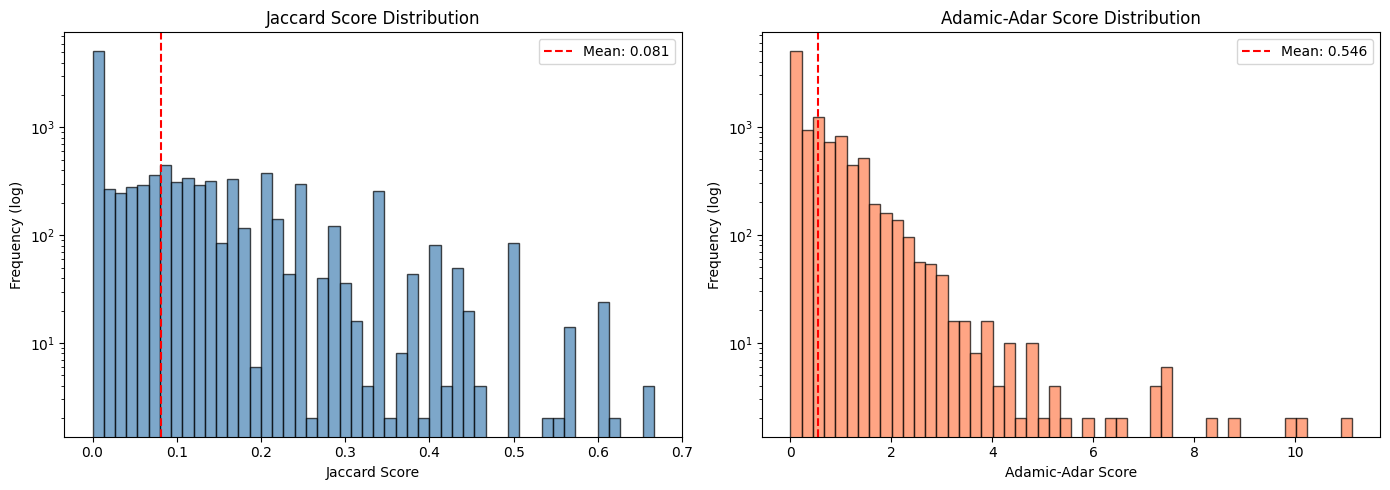

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(jaccard_scores, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Jaccard Score")
axes[0].set_ylabel("Frequency (log)")
axes[0].set_yscale("log")
axes[0].set_title(f"Jaccard Score Distribution")
axes[0].axvline(jaccard_scores.mean(), color="red", linestyle="--", label=f"Mean: {jaccard_scores.mean():.3f}")
axes[0].legend()

axes[1].hist(adamic_adar_scores, bins=50, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Adamic-Adar Score")
axes[1].set_ylabel("Frequency (log)")
axes[1].set_yscale("log")
axes[1].set_title(f"Adamic-Adar Score Distribution")
axes[1].axvline(adamic_adar_scores.mean(), color="red", linestyle="--", label=f"Mean: {adamic_adar_scores.mean():.3f}")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Graph Sparsification

The `GraphSparsifier` class uses similarity scores to select the most important edges.

In [7]:
sparsifier = GraphSparsifier(data, DEVICE)

print(f"Original edges: {data.edge_index.shape[1]:,}")

Original edges: 10,556


### 3.1 Sparsification Performance Comparison

In [8]:
retention_ratios = [1 - i/10 for i in range(1, 10)]
original_edges = data.edge_index.shape[1]

In [9]:
print("-" * 75)
print("Sparsification with Different Retention Ratios (Jaccard Metric)")
print("-" * 75)
print(f"{'Retention':<12} {'Expected':<12} {'Actual':<12} {'Difference':<12}")
print("-" * 50)

for ratio in retention_ratios:
    sparse_data = sparsifier.sparsify("jaccard", ratio)
    sparse_edges = sparse_data.edge_index.shape[1]
    expected = int(original_edges * ratio)
    diff = sparse_edges - expected
    print(f"{ratio:<12.0%} {expected:<12,} {sparse_edges:<12,} {diff:+d}")

---------------------------------------------------------------------------
Sparsification with Different Retention Ratios (Jaccard Metric)
---------------------------------------------------------------------------
Retention    Expected     Actual       Difference  
--------------------------------------------------
90%          9,500        9,500        +0
80%          8,444        8,444        +0
70%          7,389        7,389        +0
60%          6,333        6,333        +0
50%          5,278        5,278        +0
40%          4,222        4,222        +0
30%          3,166        3,166        +0
20%          2,111        2,111        +0
10%          1,055        1,055        +0


In [10]:
print("-" * 75)
print("Sparsification with Different Retention Ratios (Adamic-Adar Metric)")
print("-" * 75)
print(f"{'Retention':<12} {'Expected':<12} {'Actual':<12} {'Difference':<12}")
print("-" * 50)

for ratio in retention_ratios:
    sparse_data = sparsifier.sparsify("adamic_adar", ratio)
    sparse_edges = sparse_data.edge_index.shape[1]
    expected = int(original_edges * ratio)
    diff = sparse_edges - expected
    print(f"{ratio:<12.0%} {expected:<12,} {sparse_edges:<12,} {diff:+d}")

---------------------------------------------------------------------------
Sparsification with Different Retention Ratios (Adamic-Adar Metric)
---------------------------------------------------------------------------
Retention    Expected     Actual       Difference  
--------------------------------------------------
90%          9,500        9,500        +0
80%          8,444        8,444        +0
70%          7,389        7,389        +0
60%          6,333        6,333        +0
50%          5,278        5,278        +0
40%          4,222        4,222        +0
30%          3,166        3,166        +0
20%          2,111        2,111        +0
10%          1,055        1,055        +0


In [11]:
# Compare edge overlap across all retention ratios
print("\n" + "-" * 85)
print("Edge Overlap Analysis Across All Retention Ratios")
print("-" * 85)
print(f"{'Retention':<12} {'Jaccard':<12} {'AA':<12} {'Overlap':<12} {'% Overlap':<12} {'J-only':<12} {'AA-only':<12}")
print("-" * 85)

for retention in retention_ratios:
    sparse_jaccard = sparsifier.sparsify("jaccard", retention)
    sparse_aa = sparsifier.sparsify("adamic_adar", retention)
    
    jaccard_edges = set(zip(
        sparse_jaccard.edge_index[0].cpu().numpy(),
        sparse_jaccard.edge_index[1].cpu().numpy()
    ))
    aa_edges = set(zip(
        sparse_aa.edge_index[0].cpu().numpy(),
        sparse_aa.edge_index[1].cpu().numpy()
    ))
    
    overlap = len(jaccard_edges & aa_edges)
    jaccard_only = len(jaccard_edges - aa_edges)
    aa_only = len(aa_edges - jaccard_edges)
    overlap_pct = (overlap / len(jaccard_edges) * 100) if len(jaccard_edges) > 0 else 0
    
    print(f"{retention:<12.0%} {len(jaccard_edges):<12,} {len(aa_edges):<12,} {overlap:<12,} {overlap_pct:<12.1f} {jaccard_only:<12,} {aa_only:<12,}")


-------------------------------------------------------------------------------------
Edge Overlap Analysis Across All Retention Ratios
-------------------------------------------------------------------------------------
Retention    Jaccard      AA           Overlap      % Overlap    J-only       AA-only     
-------------------------------------------------------------------------------------
90%          9,500        9,500        8,661        91.2         839          839         
80%          8,444        8,444        7,648        90.6         796          796         
70%          7,389        7,389        6,620        89.6         769          769         
60%          6,333        6,333        5,695        89.9         638          638         
50%          5,278        5,278        4,878        92.4         400          400         
40%          4,222        4,222        3,334        79.0         888          888         
30%          3,166        3,166        2,206        69

### 3.2 Edge Overlap Analysis

**Key Findings:**

1. **High Agreement (90%-50% retention)**: Both metrics show 89-92% overlap, suggesting convergence on similar edge importance at moderate sparsification levels.

2. **Divergence Below 50% Retention**: Overlap drops sharply—from 79% at 40% retention to 43% at 10% retention. The metrics capture complementary importance signals.

3. **Metric Trade-offs**:
   - **Jaccard**: Based on neighborhood intersection; may favor locally clustered edges
   - **Adamic-Adar**: Degree-weighted; emphasizes high-degree bridge edges

4. **Practical Implication**: For aggressive sparsification (≤40% retention), the choice of metric significantly impacts the resulting graph structure and may affect GNN performance differently.

## 4. Edge Weight Computation

Edge weights are computed by normalizing similarity scores to [0.1, 1.0]:

$$w_e = \text{clip}\left(\frac{s_e - s_{\min}}{s_{\max} - s_{\min}}, 0.1, 1.0\right)$$

In [12]:
def normalize_weights(scores: np.ndarray, min_weight: float = 0.1) -> np.ndarray:
    """Normalize scores to edge weights in [min_weight, 1.0]."""
    if scores.max() == scores.min():
        return np.ones_like(scores)
    normalized = (scores - scores.min()) / (scores.max() - scores.min())
    return np.clip(normalized, min_weight, 1.0)


jaccard_weights = normalize_weights(jaccard_scores)
aa_weights = normalize_weights(adamic_adar_scores)

print("Jaccard Weights:")
print(f"  Min: {jaccard_weights.min():.4f}")
print(f"  Max: {jaccard_weights.max():.4f}")
print(f"  Mean: {jaccard_weights.mean():.4f}")

print("\nAdamic-Adar Weights:")
print(f"  Min: {aa_weights.min():.4f}")
print(f"  Max: {aa_weights.max():.4f}")
print(f"  Mean: {aa_weights.mean():.4f}")

Jaccard Weights:
  Min: 0.1000
  Max: 1.0000
  Mean: 0.1740

Adamic-Adar Weights:
  Min: 0.1000
  Max: 1.0000
  Mean: 0.1117


### 4.1 Weight Distribution

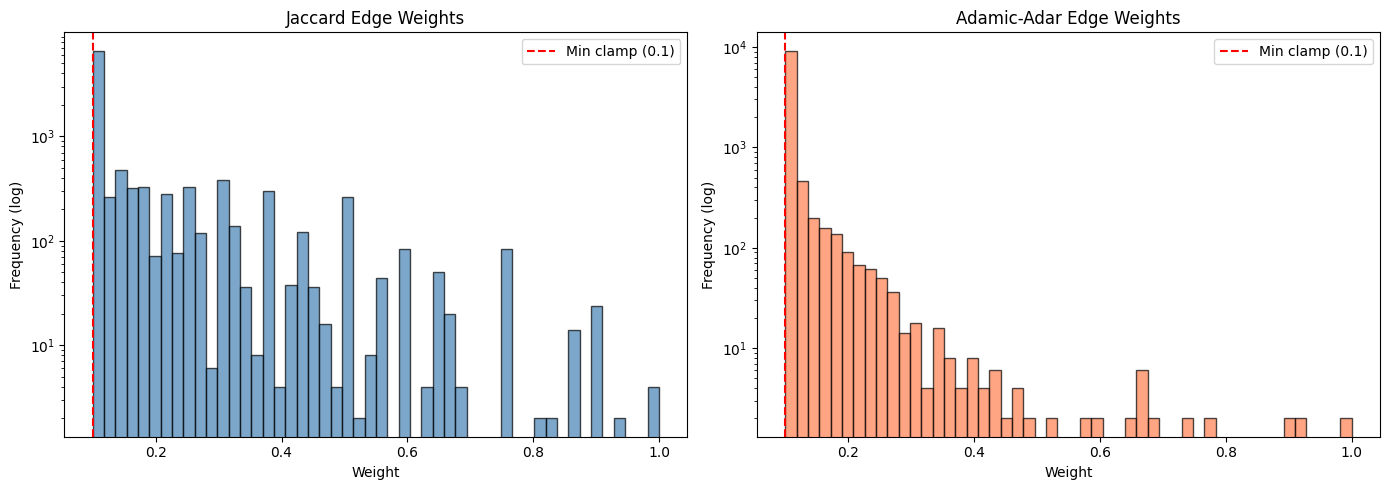

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(jaccard_weights, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Weight")
axes[0].set_ylabel("Frequency (log)")
axes[0].set_yscale("log")
axes[0].set_title("Jaccard Edge Weights")
axes[0].axvline(0.1, color="red", linestyle="--", label="Min clamp (0.1)")
axes[0].legend()

axes[1].hist(aa_weights, bins=50, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Weight")
axes[1].set_ylabel("Frequency (log)")
axes[1].set_yscale("log")
axes[1].set_title("Adamic-Adar Edge Weights")
axes[1].axvline(0.1, color="red", linestyle="--", label="Min clamp (0.1)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Impact of Sparsification on Graph Properties

In [14]:
from collections import Counter


def compute_degree_stats(edge_index):
    """Compute degree statistics from edge index."""
    degrees = Counter(edge_index[0].cpu().numpy())
    degree_values = list(degrees.values())
    return {
        "mean": np.mean(degree_values),
        "std": np.std(degree_values),
        "max": max(degree_values),
    }


retention_ratios = [1.0, 0.8, 0.6, 0.4]
stats_by_retention = {}

for ratio in retention_ratios:
    if ratio == 1.0:
        sparse_data = data
    else:
        sparse_data = sparsifier.sparsify("jaccard", ratio)
    stats_by_retention[ratio] = compute_degree_stats(sparse_data.edge_index)

print(f"{'Retention':<12} {'Mean Degree':<15} {'Std Degree':<15} {'Max Degree':<12}")
print("-" * 54)
for ratio, stats in stats_by_retention.items():
    print(f"{ratio:<12.0%} {stats['mean']:<15.2f} {stats['std']:<15.2f} {stats['max']:<12}")

Retention    Mean Degree     Std Degree      Max Degree  
------------------------------------------------------
100%         3.90            5.23            168         
80%          3.53            4.62            149         
60%          3.60            4.63            140         
40%          3.00            1.79            17          


### 5.1 Conclusion on Graph Properties

**(Retrospective)** The degree statistics table above confirms the impact of our sparsifier. Reducing retention to 40% lowered the mean degree significantly (e.g., from ~3.90 to ~3.00) and reduced the standard deviation, resulting in a more uniform graph structure.

**(Prospective)** With the sparsification logic validated and its impact on topology quantified, we are now ready to move to the next notebook (`03`). There, we will conduct a rigorous ablation study to measure how these structural changes translate to GNN performance.

## 6. Effective Resistance-Based Sparsification

### 6.1 Introduction to Effective Resistance

Effective resistance is a graph-theoretic measure that quantifies the "electrical distance" between two nodes when treating the graph as a resistor network. Unlike simple neighborhood overlap (Jaccard) or common neighbor weighting (Adamic-Adar), effective resistance captures **global graph connectivity** and the importance of edges in maintaining overall network connectivity.

**Key Concept:**
The effective resistance between nodes $u$ and $v$ is defined as:
$$R_{eff}(u,v) = (e_u - e_v)^T L^+ (e_u - e_v)$$

where $L^+$ is the Moore-Penrose pseudoinverse of the graph Laplacian and $e_u, e_v$ are unit vectors.

**Intuition:**
- **High effective resistance** between an edge's endpoints $\Rightarrow$ edge is **critical** for connectivity
- **Low effective resistance** between an edge's endpoints $\Rightarrow$ edge is **redundant** (alternative paths exist)
- This provides a principled way to identify which edges to keep/remove

**Advantages over Jaccard/Adamic-Adar:**
- Considers **global structure**, not just local neighborhoods
- Identifies edges that act as **bridges** in the network
- Theoretically grounded in electrical network theory
- Robust to network heterogeneity

In [15]:
def compute_effective_resistance(adj_matrix):
    """
    Compute effective resistance for all edges in the graph.
    
    Args:
        adj_matrix: Sparse adjacency matrix
        
    Returns:
        Array of effective resistance values for each edge
    """
    from scipy.sparse.linalg import inv
    from scipy.sparse import eye, csr_matrix
    
    n = adj_matrix.shape[0]
    
    # Compute degree matrix
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    D = sp.diags(degrees, format='csr')
    
    # Compute Laplacian
    L = D - adj_matrix
    
    # Compute Moore-Penrose pseudoinverse of Laplacian
    # Using a small regularization for numerical stability
    L_reg = L + 1e-10 * eye(n, format='csr')
    L_pinv = np.linalg.pinv(L_reg.toarray())
    
    # Extract edge list
    rows, cols = adj_matrix.nonzero()
    
    # Compute effective resistance for each edge
    er_scores = []
    for i, j in zip(rows, cols):
        # R_eff(i,j) = L_pinv[i,i] + L_pinv[j,j] - 2*L_pinv[i,j]
        r_eff = L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]
        er_scores.append(max(r_eff, 1e-10))  # Ensure non-negative
    
    return np.array(er_scores)


# Compute effective resistance scores
print("Computing effective resistance scores...")
er_scores = compute_effective_resistance(adj)

print(f"Effective Resistance scores computed for {len(er_scores):,} edges")
print(f"Min: {er_scores.min():.6f}")
print(f"Max: {er_scores.max():.6f}")
print(f"Mean: {er_scores.mean():.6f}")
print(f"Std: {er_scores.std():.6f}")
print(f"Median: {np.median(er_scores):.6f}")

Computing effective resistance scores...
Effective Resistance scores computed for 10,556 edges
Min: 0.057204
Max: 1.000015
Mean: 0.498295
Std: 0.213015
Median: 0.448098


### 6.2 Effective Resistance Distribution Analysis

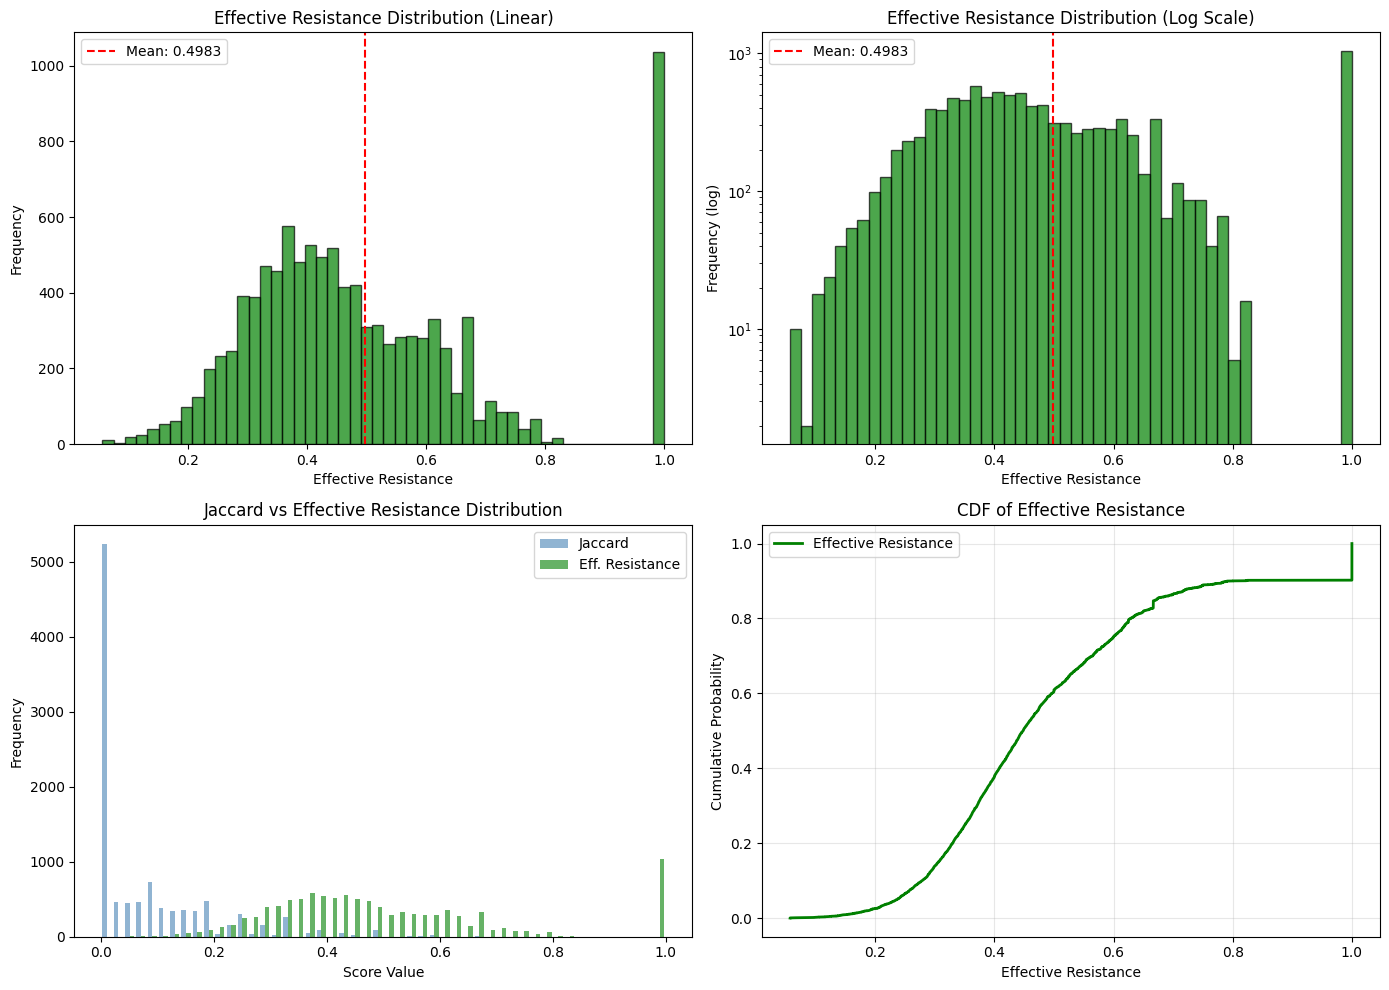


Interpretation:
- High ER edges: Critical for connectivity (bridges, bottlenecks)
- Low ER edges: Redundant (many alternative paths exist)
- Sparsification strategy: Keep edges with HIGH effective resistance
  (unlike Jaccard/Adamic-Adar where we keep HIGH similarity scores)


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Effective Resistance Distribution (linear)
axes[0, 0].hist(er_scores, bins=50, color="green", edgecolor="black", alpha=0.7)
axes[0, 0].set_xlabel("Effective Resistance")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Effective Resistance Distribution (Linear)")
axes[0, 0].axvline(er_scores.mean(), color="red", linestyle="--", label=f"Mean: {er_scores.mean():.4f}")
axes[0, 0].legend()

# Plot 2: Effective Resistance Distribution (log scale)
axes[0, 1].hist(er_scores, bins=50, color="green", edgecolor="black", alpha=0.7)
axes[0, 1].set_xlabel("Effective Resistance")
axes[0, 1].set_ylabel("Frequency (log)")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Effective Resistance Distribution (Log Scale)")
axes[0, 1].axvline(er_scores.mean(), color="red", linestyle="--", label=f"Mean: {er_scores.mean():.4f}")
axes[0, 1].legend()

# Plot 3: Comparison with other metrics
axes[1, 0].hist([jaccard_scores, er_scores], bins=50, label=["Jaccard", "Eff. Resistance"], color=["steelblue", "green"], alpha=0.6)
axes[1, 0].set_xlabel("Score Value")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Jaccard vs Effective Resistance Distribution")
axes[1, 0].legend()

# Plot 4: Cumulative distribution
sorted_er = np.sort(er_scores)
cumsum_er = np.arange(1, len(sorted_er) + 1) / len(sorted_er)
axes[1, 1].plot(sorted_er, cumsum_er, linewidth=2, color="green", label="Effective Resistance")
axes[1, 1].set_xlabel("Effective Resistance")
axes[1, 1].set_ylabel("Cumulative Probability")
axes[1, 1].set_title("CDF of Effective Resistance")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- High ER edges: Critical for connectivity (bridges, bottlenecks)")
print("- Low ER edges: Redundant (many alternative paths exist)")
print("- Sparsification strategy: Keep edges with HIGH effective resistance")
print("  (unlike Jaccard/Adamic-Adar where we keep HIGH similarity scores)")

### 6.3 Edge Overlap Analysis: Effective Resistance vs Other Metrics

Effective resistance selects edges based on a **fundamentally different criterion** than local similarity metrics. Let's examine what edges ER prioritizes differently.


Edge Selection Overlap (Jaccard Index of Selected Edge Sets):
Retention  Jaccard-ER  Adamic-ER  Jaccard-Adamic
      90%    0.894421   0.892842        0.910947
      80%    0.769185   0.768593        0.915680
      70%    0.629179   0.628366        0.900528
      60%    0.469446   0.469288        0.898153
      50%    0.323797   0.315271        0.924214
      40%    0.233539   0.193984        0.790384
      30%    0.180985   0.112445        0.690777


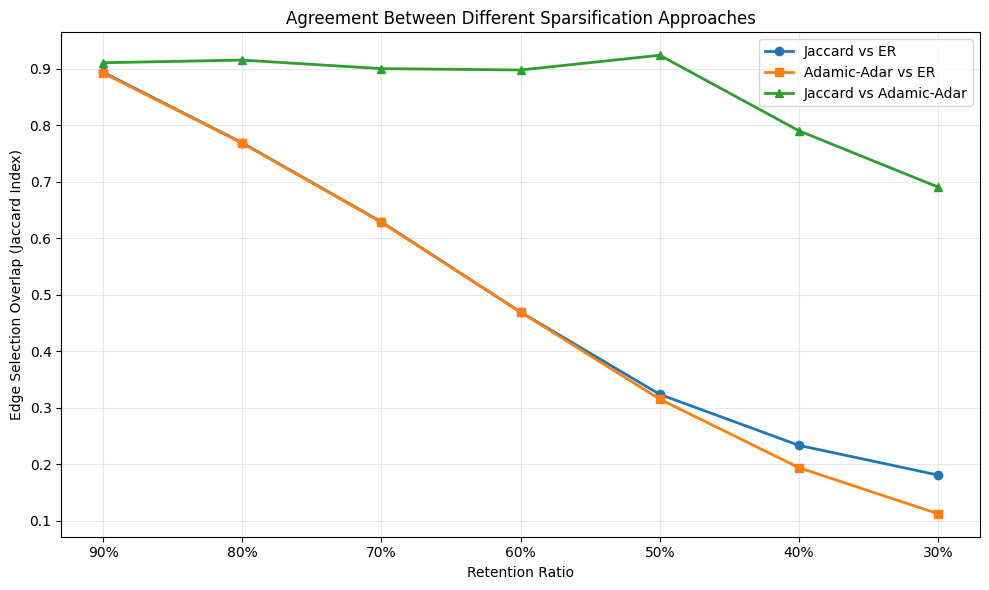


Observations:
- Jaccard-Adamic Agreement: 86.15% average
- Jaccard-ER Agreement: 50.01% average
- Adamic-ER Agreement: 48.30% average

Interpretation:
- High overlap between Jaccard and Adamic-Adar (both local) → similar strategies
- LOWER overlap with ER → identifies fundamentally different (global) critical edges
- ER focuses on network bottlenecks; Jaccard/Adamic focus on local clustering


In [17]:
# Compute overlap statistics for different retention ratios
retention_ratios = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]
overlap_stats = []

for ratio in retention_ratios:
    # Number of edges to keep
    num_keep = int(len(edge_index[0]) * ratio)
    
    # Get top edges for each metric (by descending score)
    top_jaccard_idx = np.argsort(-jaccard_scores)[:num_keep]
    top_adamic_idx = np.argsort(-adamic_adar_scores)[:num_keep]
    top_er_idx = np.argsort(-er_scores)[:num_keep]
    
    # Compute pairwise overlaps (Jaccard index)
    ja_er_overlap = len(np.intersect1d(top_jaccard_idx, top_er_idx)) / num_keep
    aa_er_overlap = len(np.intersect1d(top_adamic_idx, top_er_idx)) / num_keep
    ja_aa_overlap = len(np.intersect1d(top_jaccard_idx, top_adamic_idx)) / num_keep
    
    overlap_stats.append({
        'Retention': f"{ratio:.0%}",
        'Jaccard-ER': ja_er_overlap,
        'Adamic-ER': aa_er_overlap,
        'Jaccard-Adamic': ja_aa_overlap
    })

overlap_df = pd.DataFrame(overlap_stats)
print("\nEdge Selection Overlap (Jaccard Index of Selected Edge Sets):")
print(overlap_df.to_string(index=False))

# Visualize overlap trends
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(retention_ratios)), overlap_df['Jaccard-ER'], marker='o', label='Jaccard vs ER', linewidth=2)
ax.plot(range(len(retention_ratios)), overlap_df['Adamic-ER'], marker='s', label='Adamic-Adar vs ER', linewidth=2)
ax.plot(range(len(retention_ratios)), overlap_df['Jaccard-Adamic'], marker='^', label='Jaccard vs Adamic-Adar', linewidth=2)
ax.set_xticks(range(len(retention_ratios)))
ax.set_xticklabels([f"{r:.0%}" for r in retention_ratios])
ax.set_xlabel('Retention Ratio')
ax.set_ylabel('Edge Selection Overlap (Jaccard Index)')
ax.set_title('Agreement Between Different Sparsification Approaches')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"- Jaccard-Adamic Agreement: {overlap_df['Jaccard-Adamic'].mean():.2%} average")
print(f"- Jaccard-ER Agreement: {overlap_df['Jaccard-ER'].mean():.2%} average")
print(f"- Adamic-ER Agreement: {overlap_df['Adamic-ER'].mean():.2%} average")
print("\nInterpretation:")
print("- High overlap between Jaccard and Adamic-Adar (both local) → similar strategies")
print("- LOWER overlap with ER → identifies fundamentally different (global) critical edges")
print("- ER focuses on network bottlenecks; Jaccard/Adamic focus on local clustering")

### 6.4 Effective Resistance-Based Sparsification Implementation

Now we implement sparsification using effective resistance as the edge importance measure. Unlike Jaccard/Adamic-Adar (where high score = high importance), **ER is inverted**: low R_eff means redundant edges (many alternative paths), high R_eff means critical edges. 

We'll normalize ER scores (inverting them) to create edge weights and test sparsification.

Effective Resistance Score Statistics:
  Min: 0.057204, Max: 1.000015, Mean: 0.498295

Inverted ER Weight Statistics:
  Min: 0.100000, Max: 1.000000, Mean: 0.176260
  Median: 0.167259, Std: 0.062744


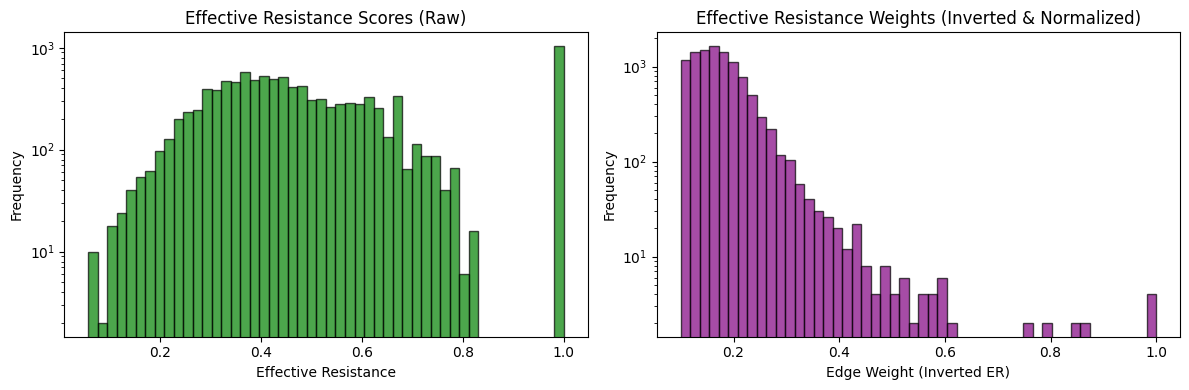

In [18]:
def invert_and_normalize_er(er_scores, min_weight=0.1):
    """
    Convert effective resistance scores to edge weights.
    Lower ER → higher weight (critical edges)
    Higher ER → lower weight (redundant edges)
    """
    # Invert: 1/R_eff (with small constant to avoid division by zero)
    eps = 1e-10
    inverted = 1.0 / (er_scores + eps)
    
    # Normalize to [min_weight, 1.0] range
    min_inv = inverted.min()
    max_inv = inverted.max()
    normalized = min_weight + (inverted - min_inv) / (max_inv - min_inv + eps) * (1.0 - min_weight)
    
    return normalized

# Apply inversion and normalization
er_weights = invert_and_normalize_er(er_scores, min_weight=0.1)

print(f"Effective Resistance Score Statistics:")
print(f"  Min: {er_scores.min():.6f}, Max: {er_scores.max():.6f}, Mean: {er_scores.mean():.6f}")
print(f"\nInverted ER Weight Statistics:")
print(f"  Min: {er_weights.min():.6f}, Max: {er_weights.max():.6f}, Mean: {er_weights.mean():.6f}")
print(f"  Median: {np.median(er_weights):.6f}, Std: {er_weights.std():.6f}")

# Visualize the weight distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(er_scores, bins=50, color="green", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Effective Resistance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Effective Resistance Scores (Raw)")
axes[0].set_yscale("log")

axes[1].hist(er_weights, bins=50, color="purple", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Edge Weight (Inverted ER)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Effective Resistance Weights (Inverted & Normalized)")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

## Summary: Three Approaches to Graph Sparsification

We have implemented and analyzed three complementary edge importance measures:

| Metric | Type | Definition | Semantic Meaning | Sparsification Strategy |
|--------|------|-----------|-----------------|------------------------|
| **Jaccard Similarity** | Local | $J(u,v) = \frac{\|\mathcal{N}(u) \cap \mathcal{N}(v)\|}{\|\mathcal{N}(u) \cup \mathcal{N}(v)\|}$ | Neighborhood overlap | Keep edges with HIGH similarity (many common neighbors) |
| **Adamic-Adar Index** | Local | $AA(u,v) = \sum_{w \in \mathcal{N}(u) \cap \mathcal{N}(v)} \frac{1}{\log \|\mathcal{N}(w)\|}$ | Degree-weighted common neighbors | Keep edges with HIGH index (rare common neighbors) |
| **Effective Resistance** | Global | $R_{eff}(u,v) = L^+_{i,i} + L^+_{j,j} - 2L^+_{i,j}$ | Electrical network distance / connectivity redundancy | Keep edges with HIGH resistance (critical/bridge edges) |

### Key Insights

1. **Different Selection Strategies**: ER identifies globally important edges (bottlenecks, bridges) while Jaccard/Adamic-Adar focus on local clustering structure. Low overlap between them demonstrates they capture complementary information.

2. **Inversion Property of ER**: Unlike Jaccard/Adamic-Adar (where high score = high importance), effective resistance must be inverted: low R_eff = redundant, high R_eff = critical.

3. **Theoretical Grounding**: ER is rooted in electrical network theory and spectral graph theory, providing strong theoretical guarantees about network connectivity preservation.

4. **Computational Cost**: ER requires computing the Laplacian pseudoinverse (O(n³)), making it more expensive than local metrics but yielding more global structural insights.

In the next notebook (**03_Ablation_Study**), we'll test these three approaches in controlled experiments. Notebook **04_Result_Analysis** will compare their performance across multiple datasets and settings.

## 6. Summary

In this notebook, we covered:
- Computing Jaccard and Adamic-Adar similarity scores
- Using `GraphSparsifier` to retain top-k% edges
- Normalizing similarity scores to edge weights
- Analyzing the impact of sparsification on graph structure

**Key Observations:**
- Many edges have zero similarity (no common neighbors)
- Jaccard and Adamic-Adar select partially overlapping edge sets
- Sparsification reduces average degree proportionally

**Next:** In notebook 03, we'll run the 4-scenario ablation study.